<a href="https://colab.research.google.com/github/ife-dolapo/Sentiment-Analysis-LLM-and-NLP/blob/main/Assignment_10_Customer_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade transformers

In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 36.8 MB/s eta 0:00:00


In [3]:
!pip install datasets

In [1]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [8]:
# Task 1: Dataset Selection and Preprocessing
# Load dataset
import pandas as pd
Imdb_Review_df = pd.read_csv('IMDB Dataset.csv', on_bad_lines='skip', engine='python')
print(Imdb_Review_df.head())

# Handling missing values
print(Imdb_Review_df.isnull().sum())

# Handling duplicates
print(Imdb_Review_df.duplicated().sum())

# Text Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Remove HTML tags, punctuation and lowercase the text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

Imdb_Review_df['cleaned_review'] = Imdb_Review_df['review'].apply(clean_text)

# Label Encoding
# Convert sentiment labels to binary
Imdb_Review_df['sentiment_encoded'] = Imdb_Review_df['sentiment'].map({'positive':1, 'negative': 0})

# Check Class balance
print(Imdb_Review_df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
review       0
sentiment    0
dtype: int64
418


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [9]:
# Task 2: Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(Imdb_Review_df['cleaned_review']).toarray()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(Imdb_Review_df['cleaned_review']).toarray()

# Word Embeddings(Word2Vec)
from gensim.models import Word2Vec

# Tokenize reviews
tokenized_reviews = [review.split() for review in Imdb_Review_df['cleaned_review']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Function to convert a tokenized review into a single numerical vector
import numpy as np

def average_word_vectors(tokens, model, vector_size):
    valid_words = [word for word in tokens if word in model.wv]
    if valid_words:
        return np.mean([model.wv[word] for word in valid_words], axis=0)
    else:
        return np.zeros(vector_size)

X_w2v = np.array([average_word_vectors(tokens, word2vec_model, 100) for tokens in tokenized_reviews])

In [10]:
# Task 3:
from sklearn.model_selection import train_test_split

X = X_tfidf  # or X_bow or X_w2v
y = Imdb_Review_df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Logistic Regression with Grid Search
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [ 0.1, 1, 10],
              'penalty':[ 'l2'],
              'solver': ['liblinear']}

grid_search_lr = GridSearchCV(logreg,
                           param_grid_lr,
                           cv=5,
                           scoring='accuracy',
                           verbose=1)
grid_search_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_search_lr.best_params_)
print("Best Logistic Regression Accuracy:", grid_search_lr.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.85875


In [12]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(max_iter=1000)
param_grid_linear_svc = {'C': [0.1, 1, 10]}

grid_search_linear_svc = GridSearchCV(linear_svc,
                                      param_grid_linear_svc,
                                      cv=3,
                                      scoring='accuracy',
                                      verbose=1,
                                      n_jobs=-1)
grid_search_linear_svc.fit(X_train, y_train)

print("Best LinearSVC Params:", grid_search_linear_svc.best_params_)
print("Best LinearSVC Accuracy:", grid_search_linear_svc.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best LinearSVC Params: {'C': 0.1}
Best LinearSVC Accuracy: 0.8578999048247543


In [13]:
import torch
print(torch.__version__)

2.8.0+cu126


In [14]:
# Task 4:
# Create label column for Hugging Face
small_df = Imdb_Review_df.sample(n=1000, random_state=42)
small_df['label'] = small_df['sentiment_encoded']
# Convert DataFrame for BERT
from datasets import Dataset

bert_dataset = Dataset.from_pandas(small_df)

In [15]:
# Tokenize the reviews
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = bert_dataset.map(tokenize_function, batched=True)

# Set Format for PyTorch
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
# Split into Train and Validation Sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']


In [17]:
# Load Pre-trained BERT Model (this loads BERT with a classification head for binary sentiment prediction)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Define Training Arguments (these control how BERT trains - batch size, epochs, evaluation frequency)
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",           # Local directory only
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    fp16=True,                        # ✅ Enabled for faster GPU training
    report_to=[],                     # disables all logging (no WandB, no HF Hub)
    hub_token=None,                   # disables hub auth
    push_to_hub=False                 # disables hub upload
)


In [22]:
# Define and Launch Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipython-input-3326573849.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.703900
200,0.479100
300,0.223200


TrainOutput(global_step=300, training_loss=0.4687173016866048, metrics={'train_runtime': 83.8673, 'train_samples_per_second': 28.617, 'train_steps_per_second': 3.577, 'total_flos': 157866633216000.0, 'train_loss': 0.4687173016866048, 'epoch': 3.0})

In [23]:
# Task 5: Model Evaluation and Accuracy Comparison

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define metrics function for BERT
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Reinitialize Trainer with metrics
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate BERT
bert_metrics = trainer.evaluate()

# Accuracy from classical models (already computed)
logistic_acc = 0.85875
svm_acc = 0.8578999048247543
bert_acc = bert_metrics['eval_accuracy']

# Print comparison
print("Model Accuracy Comparison:")
print(f"Logistic Regression: {logistic_acc:.4f}")
print(f"SVM:                {svm_acc:.4f}")
print(f"BERT:               {bert_acc:.4f}")

/tmp/ipython-input-3471861795.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model Accuracy Comparison:
Logistic Regression: 0.8588
SVM:                0.8579
BERT:               0.8450


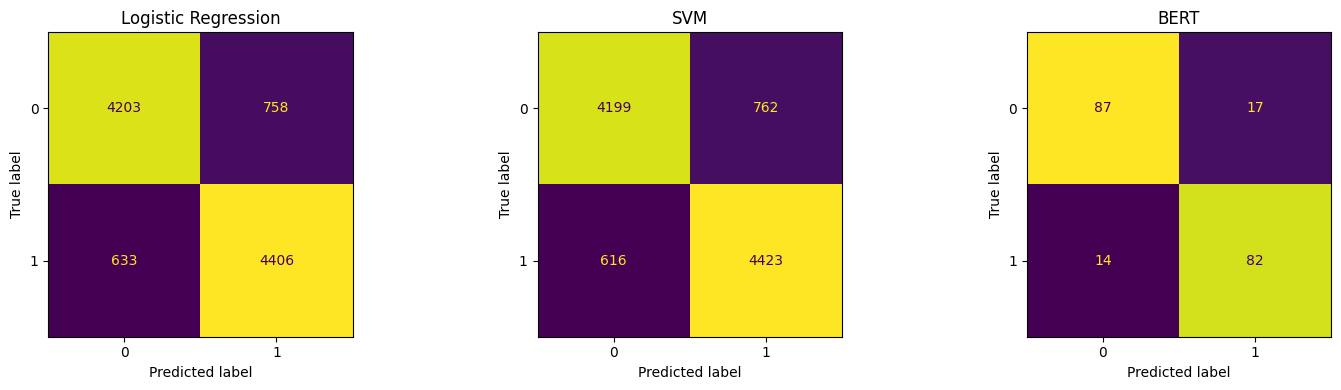

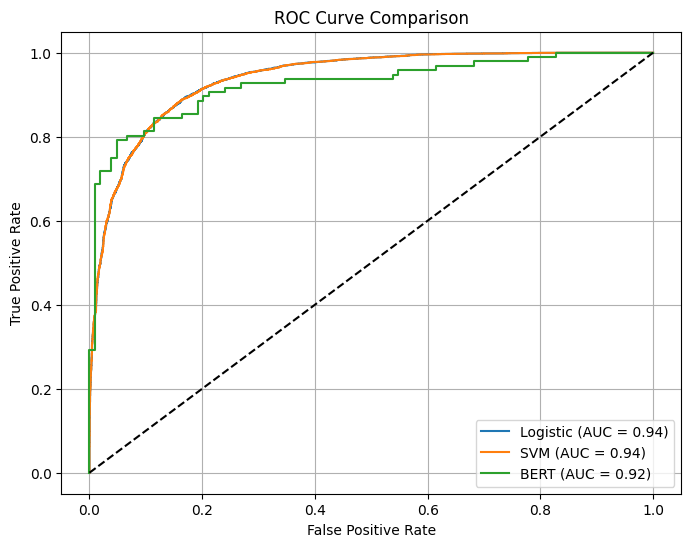

In [25]:
# Task 5: Confusion Matrices and ROC Curves

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predictions
logistic_preds = grid_search_lr.predict(X_test)
svm_preds = grid_search_linear_svc.predict(X_test)
bert_raw_preds = trainer.predict(valid_dataset)
bert_preds = bert_raw_preds.predictions.argmax(-1)
bert_labels = bert_raw_preds.label_ids

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, preds, labels, title in zip(
    axes,
    [logistic_preds, svm_preds, bert_preds],
    [y_test, y_test, bert_labels],
    ["Logistic Regression", "SVM", "BERT"]
):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# ROC Curves
# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0, 1])
bert_labels_bin = label_binarize(bert_labels, classes=[0, 1])

# Probabilities / decision scores
logistic_probs = grid_search_lr.predict_proba(X_test)[:, 1]
svm_probs = grid_search_linear_svc.decision_function(X_test)
bert_probs = bert_raw_preds.predictions[:, 1]

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test_bin, logistic_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, svm_probs)
fpr_bert, tpr_bert, _ = roc_curve(bert_labels_bin, bert_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc(fpr_log, tpr_log):.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc(fpr_svm, tpr_svm):.2f})")
plt.plot(fpr_bert, tpr_bert, label=f"BERT (AUC = {auc(fpr_bert, tpr_bert):.2f})")

print()
print()

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()